<a href="https://colab.research.google.com/github/Taciana3090/LH_AW_TacianaVasconcelos/blob/Taciana3090%2Fmain/Previs%C3%A3o_de_Demanda_AW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 align="center"><font color = #0081be>**Previsão de Demanda**</font></h1>


A empresa Adventure Works (AW) é uma indústria de bicicletas com mais de 500 produtos distintos, 20.000 clientes e 31.000 pedidos. Nesse desafio, será realizada uma previsão de demanda, a fim, de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima.

> <a><font color = #0081be>**1.**</font></a> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

>  <a><font color = #0081be>**2.**</font></a> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.
   
> <a><font color = #0081be>**3.**</font></a> Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 1?
   
> <a><font color = #0081be>**4.**</font></a> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?


## <a><font color = #0081be>**Objetivos**</font></a>
*Prever a demanda dos próximos três meses de cada produto em cada loja e identificar sazonalidade. Além disso, responder às questões relacionadas a centros de distribuição, zíperes, e crescimento por província ou país.*

# <h1 align="center"><font color = #0081be>Configuração Inicial e Importação de Bibliotecas</font></h1>

In [1]:
!pip install optuna --quiet
!pip install pandas-gbq --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
!pip install snowflake-connector-python --quiet
!pip install pmdarima --quiet
!pip install hierarchicalforecast --quiet
!pip install datasetsforecast --quiet
!pip install statsforecast
!pip install unidecode --quiet
!pip install catboost
!pip install --upgrade xgboost scikit-learn
!pip cache purge
!pip install pandas==2.2.2

Files removed: 4


In [2]:
# importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import snowflake.connector
import warnings
from datetime import datetime
from tqdm import tqdm
import scipy.stats as stats
from pylab import rcParams
from google.colab import drive
import matplotlib.ticker as mticker
from unidecode import unidecode
from itertools import product

# bibliotecas para séries temporais
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima

# métricas de avaliação
from sklearn.metrics import (
    mean_squared_error as MSE,
    r2_score,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# aprendizado de máquina
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# pipeline e pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler
)

# otimização e salvamento de modelos
import optuna
import joblib
import pickle

# bibliotecas para reconciliação hierárquica e previsão
from statsforecast.models import AutoARIMA, Naive
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp
from hierarchicalforecast.utils import aggregate
from statsforecast import StatsForecast
import statsmodels.api as sm
import xgboost as xgb

# removendo warnings
warnings.filterwarnings('ignore')

# configurando pandas para exibir mais linhas e colunas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# ajustando o estilo e tamanho das figuras
sns.set_theme(rc={'figure.figsize': (12, 8)})

# configurando exibição de floats com 3 casas decimais
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# <h1 align="center"><font color = #0081be>Conexão e Carregamento dos dados  - Snowflake</font></h1>

In [3]:
# arquivo de chave
key_file = '/content/snowflake_credentials.json'


with open(key_file, 'r') as file:
    credentials = json.load(file)

# credenciais
try:
    conn = snowflake.connector.connect(
        user=credentials['user'],
        password=credentials['password'],
        account=credentials['account'],
        warehouse=credentials['warehouse'],
        database=credentials['database'],
        schema=credentials['schema']
    )
    print("Conexão com Snowflake bem-sucedida!")
except Exception as e:
    print("Erro ao conectar ao Snowflake:", e)

Conexão com Snowflake bem-sucedida!


In [4]:
# dados da tabela agg_by_ml
query = "select * from agg_by_ml"

# carrega os dados
try:
    df_demanda = pd.read_sql(query, conn)
    print("Dados carregados com sucesso no DataFrame!")
except Exception as e:
    print("Erro ao carregar os dados:", e)

# arquivo parquet
df_demanda.to_parquet("agg_by_ml.parquet", engine="pyarrow", index=False)
print("Dados salvos em formato Parquet!")

Dados carregados com sucesso no DataFrame!
Dados salvos em formato Parquet!


In [5]:
drive.mount('/content/drive')
# acessa o arquivo parquet
file_path = "/content/agg_by_ml.parquet"
df_demanda = pd.read_parquet(file_path, engine="pyarrow")
df = pd.read_parquet(file_path, engine="pyarrow")
print("Dados carregados com sucesso do Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dados carregados com sucesso do Google Drive!


# <h1 align="center"><font color = #0081be>Analisando a Base de Dados</font></h1>

In [6]:
# análise aleatória
df_demanda.sample(3)

,ORDER_DATE,PRODUCT_ID,TERRITORY_NAME,COUNTRYREGION_CODE,ONLINE_ORDER_FLAG,SALES_PERSON_ID,UNIT_PRICE,UNIT_PRICE_DISCOUNT,ORDER_QUANTITY,FREIGHT,STORE_NAME,PRODUCT_NAME,PRODUCT_NUMBER,NAME_PRODUCT_CATEGORY,NAME_PRODUCT_SUBCATEGORY,STATE_PROVINCE_NAME,TOTAL_INVENTORY,TOTAL_ORDERS
2762518,2013-07-31,899,Canada,CA,False,278,200.052,0.000,2,"1,165.064",General Riding Supplies,"LL Touring Frame - Yellow, 44",FR-T67Y-44,Components,Touring Frames,British Columbia,0,1
1746615,2013-12-31,867,Northeast,US,False,277,41.994,0.000,10,25.269,Sheet Metal Manufacturing,"Women's Mountain Shorts, S",SH-W890-S,Clothing,Shorts,Texas,216,1
1432806,2012-05-30,794,Canada,CA,False,289,"1,308.938",0.000,4,"3,672.498",Authentic Sales and Service,"Road-250 Black, 48",BK-R89B-48,Bikes,Road Bikes,England,165,1


In [7]:
print(f"A base de dados contém {df_demanda.shape[0]} linhas e {df_demanda.shape[1]} colunas.")

A base de dados contém 3368243 linhas e 18 colunas.


In [8]:
# colunas
df_demanda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3368243 entries, 0 to 3368242
Data columns (total 18 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ORDER_DATE                datetime64[ns]
 1   PRODUCT_ID                int64         
 2   TERRITORY_NAME            object        
 3   COUNTRYREGION_CODE        object        
 4   ONLINE_ORDER_FLAG         bool          
 5   SALES_PERSON_ID           int64         
 6   UNIT_PRICE                float64       
 7   UNIT_PRICE_DISCOUNT       float64       
 8   ORDER_QUANTITY            int64         
 9   FREIGHT                   float64       
 10  STORE_NAME                object        
 11  PRODUCT_NAME              object        
 12  PRODUCT_NUMBER            object        
 13  NAME_PRODUCT_CATEGORY     object        
 14  NAME_PRODUCT_SUBCATEGORY  object        
 15  STATE_PROVINCE_NAME       object        
 16  TOTAL_INVENTORY           int64         
 17  TOTAL_OR

In [9]:
# valores ausentes e porcentagem (decrescente)
missing_values = df_demanda.isna().sum()
percent_missing = (missing_values / len(df_demanda)) * 100
missing_data = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Porcentagem de Valores Ausentes': percent_missing
})
missing_data = missing_data.sort_values(by='Valores Ausentes', ascending=False)
missing_data['Porcentagem de Valores Ausentes'] = missing_data['Porcentagem de Valores Ausentes'].apply('{:.2f}%'.format)
missing_data

,Valores Ausentes,Porcentagem de Valores Ausentes
ORDER_DATE,0,0.00%
PRODUCT_ID,0,0.00%
TOTAL_INVENTORY,0,0.00%
STATE_PROVINCE_NAME,0,0.00%
NAME_PRODUCT_SUBCATEGORY,0,0.00%
NAME_PRODUCT_CATEGORY,0,0.00%
PRODUCT_NUMBER,0,0.00%
PRODUCT_NAME,0,0.00%
STORE_NAME,0,0.00%
FREIGHT,0,0.00%


In [10]:
# não há duplicação.
df_demanda[df_demanda.duplicated()]


,ORDER_DATE,PRODUCT_ID,TERRITORY_NAME,COUNTRYREGION_CODE,ONLINE_ORDER_FLAG,SALES_PERSON_ID,UNIT_PRICE,UNIT_PRICE_DISCOUNT,ORDER_QUANTITY,FREIGHT,STORE_NAME,PRODUCT_NAME,PRODUCT_NUMBER,NAME_PRODUCT_CATEGORY,NAME_PRODUCT_SUBCATEGORY,STATE_PROVINCE_NAME,TOTAL_INVENTORY,TOTAL_ORDERS


In [11]:
# estatísticas descritivas
df_demanda.describe()

,ORDER_DATE,PRODUCT_ID,SALES_PERSON_ID,UNIT_PRICE,UNIT_PRICE_DISCOUNT,ORDER_QUANTITY,FREIGHT,TOTAL_INVENTORY,TOTAL_ORDERS
count,3368243,"3,368,243.000","3,368,243.000","3,368,243.000","3,368,243.000","3,368,243.000","3,368,243.000","3,368,243.000","3,368,243.000"
mean,2013-03-01 20:18:29.365564160,826.677,279.904,450.972,0.005,3.462,"1,248.846",241.556,1.000
min,2011-05-31 00:00:00,707.000,275.000,1.374,0.000,1.000,0.034,0.000,1.000
25%,2012-07-31 00:00:00,761.000,277.000,35.994,0.000,2.000,707.090,129.000,1.000
50%,2013-04-30 00:00:00,808.000,279.000,218.454,0.000,3.000,"1,090.442",164.000,1.000
75%,2013-10-30 00:00:00,883.000,282.000,672.294,0.000,4.000,"1,673.663",252.000,1.000
max,2014-05-01 00:00:00,999.000,290.000,"2,146.962",0.400,44.000,"5,608.912","1,978.000",2.000
std,NaN,85.780,4.524,525.965,0.034,2.983,863.265,248.892,0.008


In [12]:
df_demanda.describe(include='object').T

,count,unique,top,freq
TERRITORY_NAME,3368243,10,Southwest,829963
COUNTRYREGION_CODE,3368243,6,US,2372339
STORE_NAME,3368243,699,Sports Products Store,10526
PRODUCT_NAME,3368243,250,AWC Logo Cap,66828
PRODUCT_NUMBER,3368243,250,CA-1098,66828
NAME_PRODUCT_CATEGORY,3368243,4,Bikes,1393282
NAME_PRODUCT_SUBCATEGORY,3368243,33,Road Bikes,772077
STATE_PROVINCE_NAME,3368243,65,California,428808


#### **Informações extraídas até aqui:**

**Informações Extraídas dos Dados**

*A base de dados contém 3.368.243 registros organizados em 18 colunas, abrangendo informações de vendas, inventário, montagem e localidades. O período analisado é de maio de 2011 a maio de 2014, permitindo identificar tendências e padrões temporais ao longo de três anos.*


**Resumo Estatístico:**

- **Produtos:** 250 produtos únicos, organizados em 4 categorias principais (ex.: Bikes, Acessórios) e 33 subcategorias. O produto mais registrado é o AWC Logo Cap, com 66.828 vendas, enquanto a loja com mais vendas registradas é a Sports Products Store.

- **Regiões e Localidades:** 10 territórios em 6 regiões/países, com destaque para os EUA, o mercado mais representado.

- **Demanda e Vendas:** A receita total (TOTAL_SALES) e o ticket médio (AVG_SALES_PER_ORDER) sugerem potenciais oportunidades para ajustes de preços ou promoções. O volume de pedidos (ORDER_QUANTITY) vai de 1 a 44 unidades por pedido, com uma média de 3,46 unidades por pedido.

- **Inventário e Montagem:** O inventário total (TOTAL_INVENTORY) varia de 0 a 10.620 unidades, enquanto os componentes de montagem possuem 2.014.162 combinações únicas e 488 configurações diferentes.

- **Frete:** Os custos de frete (FREIGHT) variam de 0,03 a 5.608,91, evidenciando diferentes tipos de pedidos (tamanho e complexidade).

- **Descontos e Preços:** O desconto unitário (UNIT_PRICE_DISCOUNT) é baixo, com média de 0,5% e máximo de 40% em pedidos específicos.
O preço médio por unidade (UNIT_PRICE) é de 450,97, com variação entre 1,37 e 2.146,96.

**Insights:**

- **Variações Temnporais:** A granularidade mensal e a dispersão de valores no ticket médio sugerem a necessidade de identificar padrões sazonais ou campanhas promocionais bem-sucedidas para replicação em anos futuros.

- **Oportunidades Regionais:** EUA lidera as vendas, mas explorar regiões sub-representadas pode revelar novas oportunidades de crescimento.

- **Planejamento Operacional:** A ampla diversidade de combinações de montagem destaca a necessidade de previsões precisas para alinhar inventário e produção.

- **Foco nos Produtos e Categorias:** A análise de categorias mais lucrativas, como Bikes, pode ser aprofundada para destacar produtos com melhor margem ou crescimento pontencial.
Produtos como o AWC Logo Cap podem ser estratégicos para campanhas devido à sua alta rotatividade.

# <h1 align="center"><font color = #0081be>Pré-processamento, transformação e análise exploratória da base de dados(EDA)</font></h1>

In [13]:
# renomeando as colunas e padronizando. tudo minúsculo
df_demanda.columns = [column.lower() for column in df_demanda.columns]
df_demanda.sample(2)

,order_date,product_id,territory_name,countryregion_code,online_order_flag,sales_person_id,unit_price,unit_price_discount,order_quantity,freight,store_name,product_name,product_number,name_product_category,name_product_subcategory,state_province_name,total_inventory,total_orders
1222138,2012-09-30,814,Northeast,US,False,275,209.256,0.000,1,"1,073.421",Economic Parts Supply,"ML Mountain Frame - Black, 38",FR-M63B-38,Components,Mountain Frames,Rhode Island,767,1
2456367,2013-03-30,793,Southwest,US,False,276,"1,308.938",0.000,3,"1,525.576",Alpine Ski House,"Road-250 Black, 44",BK-R89B-44,Bikes,Road Bikes,California,134,1


In [14]:
df_demanda['country_store_group'] = df_demanda['countryregion_code'] + ' - ' + df_demanda['territory_name']

In [15]:
# padronizar colunas categóricas
categorical_columns = ['territory_name', 'countryregion_code',
                       'store_name', 'product_name',
                       'product_number', 'name_product_category', 'name_product_subcategory',
                        'state_province_name']
for col in categorical_columns:
    df_demanda[col] = df_demanda[col].str.lower().str.strip()

In [16]:
# limites usando IQR diretamente
Q1 = df_demanda['order_quantity'].quantile(0.25)
Q3 = df_demanda['order_quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(0, Q1 - 1.5 * IQR)  # evita valores negativos
upper_bound = Q3 + 1.5 * IQR
# filtra os dados e conta outliers
outliers_baixos = df_demanda[df_demanda['order_quantity'] < lower_bound]
outliers_altos = df_demanda[df_demanda['order_quantity'] > upper_bound]
print(f"Limite Inferior: {lower_bound}")
print(f"Limite Superior: {upper_bound}")
print(f"Outliers abaixo do limite: {len(outliers_baixos)}")
print(f"Outliers acima do limite: {len(outliers_altos)}")
print(f"Dimensão original: {df_demanda.shape}")
print(f"Dimensão após filtro: {df_demanda[(df_demanda['order_quantity'] >= lower_bound) & (df_demanda['order_quantity'] <= upper_bound)].shape}")


Limite Inferior: 0
Limite Superior: 7.0
Outliers abaixo do limite: 0
Outliers acima do limite: 271045
Dimensão original: (3368243, 19)
Dimensão após filtro: (3097198, 19)


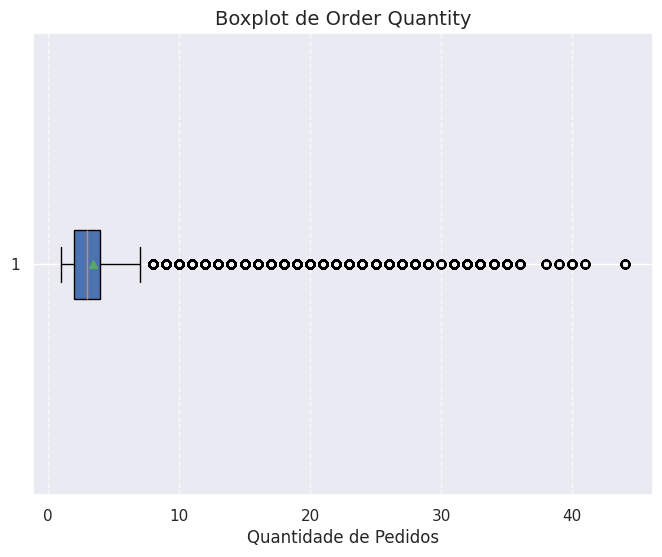

In [17]:
# boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df_demanda['order_quantity'], vert=False, patch_artist=True, showmeans=True)
plt.title('Boxplot de Order Quantity', fontsize=14)
plt.xlabel('Quantidade de Pedidos', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


*O método IQR foi usado para identificar outliers em order_quantity. Os limites definidos foram 0 (inferior) e 7.0 (superior). Foram encontrados 271.045 outliers acima do limite superior, representando cerca de 8% dos dados.*

In [18]:
df_demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3368243 entries, 0 to 3368242
Data columns (total 19 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   order_date                datetime64[ns]
 1   product_id                int64         
 2   territory_name            object        
 3   countryregion_code        object        
 4   online_order_flag         bool          
 5   sales_person_id           int64         
 6   unit_price                float64       
 7   unit_price_discount       float64       
 8   order_quantity            int64         
 9   freight                   float64       
 10  store_name                object        
 11  product_name              object        
 12  product_number            object        
 13  name_product_category     object        
 14  name_product_subcategory  object        
 15  state_province_name       object        
 16  total_inventory           int64         
 17  total_or

In [19]:
def plot_order_quantity_general(df_grouped, aggregation_name, figsize=(12, 4), top_n=10):
    """
    plota a quantidade de pedidos agrupados por qualquer agregação (país, estado, cidade, etc.), limitando aos top_n maiores.

    parâmetros:
        df_grouped (Series): série pandas com índices (país, estado, cidade, etc.) e a quantidade de pedidos como valores.
        aggregation_name (str): nome da agregação para exibir no gráfico.
        figsize (tuple): tamanho da figura (largura, altura).
        top_n (int): número de itens a exibir (padrão: 10).
    """
    #os top_n maiores valores
    df_grouped = df_grouped.sort_values(ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.cm.Blues(df_grouped / df_grouped.max())
    bars = ax.barh(df_grouped.index, df_grouped.values, color=colors, edgecolor='black')
    for bar in bars:
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
                f'{int(bar.get_width()):,}'.replace(',', '.'), va='center', fontsize=10)
    # configurações do gráfico
    ax.set_title(f'Quantidade de Pedidos por {aggregation_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Quantidade de Pedidos', fontsize=12)
    ax.set_ylabel(aggregation_name, fontsize=12)
    ax.invert_yaxis()
    ax.grid(False)
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    plt.tight_layout()
    plt.show()

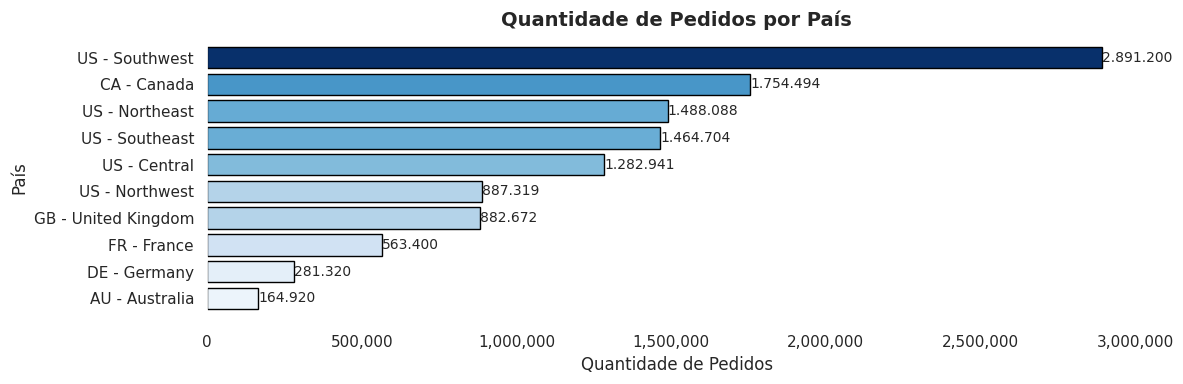

In [20]:
# quantidade de pedidos por país
demanda_país = df_demanda.groupby('country_store_group')['order_quantity'].sum()
plot_order_quantity_general(demanda_país, aggregation_name='País')

*Os EUA lideram em pedidos, indicando maior operação ou demanda no mercado. Como segundo maior mercado, o Canadá sugere potencial para expansão ou maior atenção.*

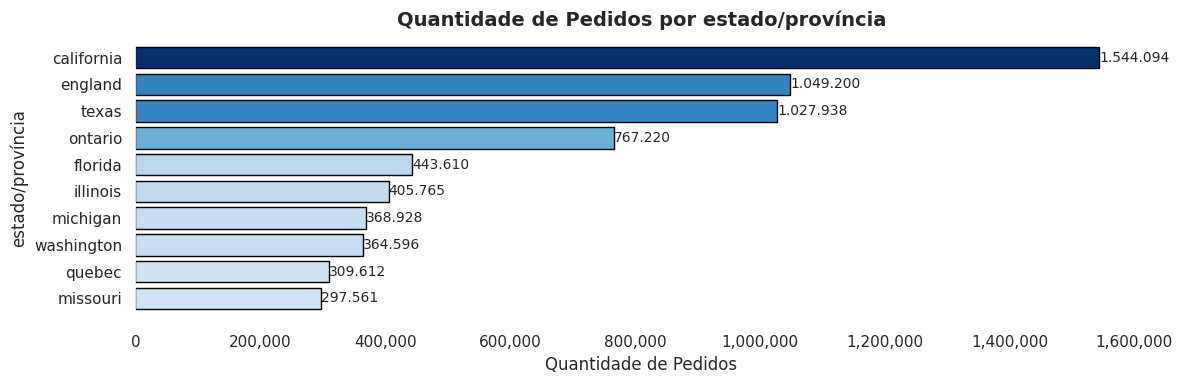

In [21]:
# quantidade de pedidos por estado
demanda_estado = df_demanda.groupby('state_province_name')['order_quantity'].sum()
plot_order_quantity_general(demanda_estado, aggregation_name='estado/província')


*A Califórnia é o estado com a maior quantidade de pedidos, indicando o principal mercado em termos de demanda. Texas e England também registram volumes relevantes de pedidos, podendo ser prioridades para expansão ou estratégias específicas.*

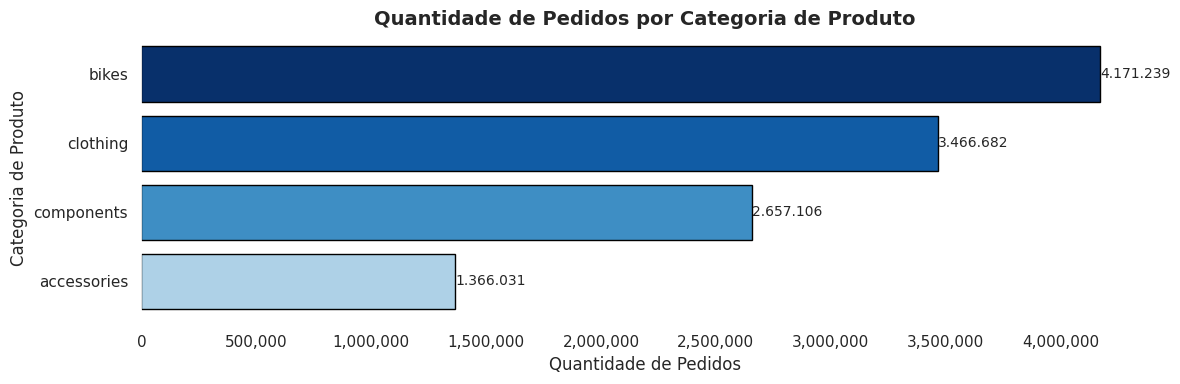

In [22]:
# quantidade de pedidos por categoria de produto
demanda_categoria = df_demanda.groupby('name_product_category')['order_quantity'].sum()
plot_order_quantity_general(demanda_categoria, aggregation_name='Categoria de Produto')

*Bikes lideram em quantidade de pedidos, indicando ser o principal segmento em demanda. Clothing aparece em segundo lugar, mostrando relevância como uma categoria complementar no mercado.*

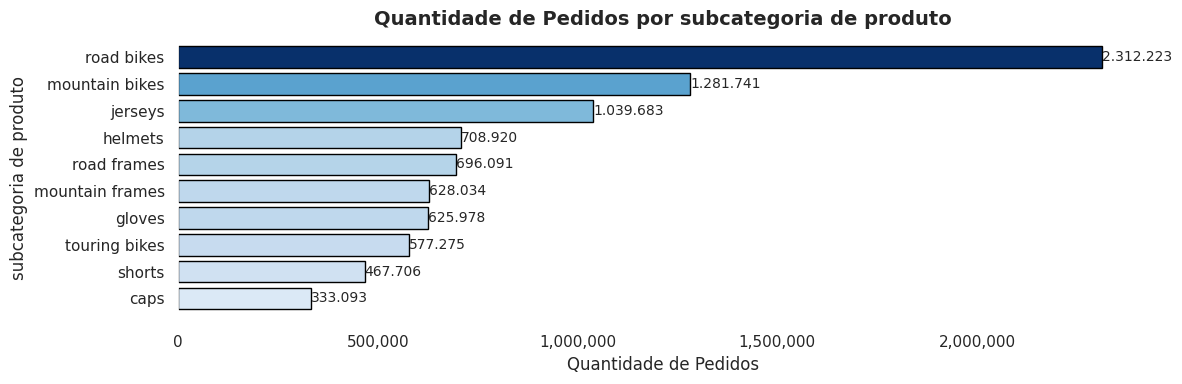

In [23]:
# quantidade de pedidos por subcategoria de produto
demanda_subcategoria = df_demanda.groupby('name_product_subcategory')['order_quantity'].sum()
plot_order_quantity_general(demanda_subcategoria, aggregation_name='subcategoria de produto', top_n=10)


*Road bikes possuem a maior quantidade de pedidos, seguidas por mountain bikes e jerseys. Caps apresentam a menor demanda entre as top 10 subcategorias.*

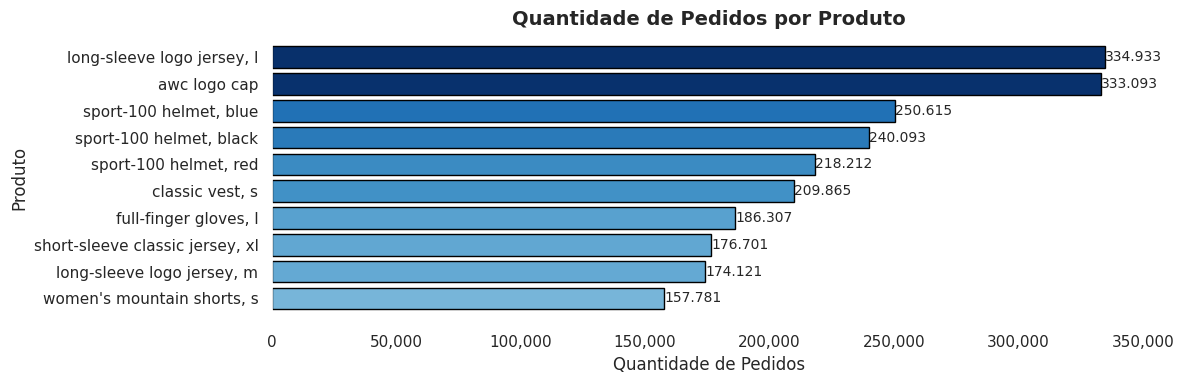

In [24]:
# quantidade de pedidos por produto
demanda_produto = df_demanda.groupby('product_name')['order_quantity'].sum()
plot_order_quantity_general(demanda_produto, aggregation_name= 'Produto')

*Os dados indicam picos de alta demanda associados a eventos sazonais ou campanhas, com variações que sugerem sazonalidade e mudanças no comportamento dos clientes.*

# <h1 align="center"><font color = #0081be>Feature Engeneering</font></h1>

In [25]:
def plot_temporal_column_distribution(df: pd.DataFrame, column_name: str) -> None:
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')
    fig, axs = plt.subplots(2, 1, figsize=(20, 12))
    daily_counts = df[column_name].dt.date.value_counts().sort_index()
    axs[0].plot(daily_counts.index, daily_counts.values, marker='o')
    axs[0].set_title(f'Contagem Diária de {column_name}')
    axs[0].set_xlabel('Data')
    axs[0].set_ylabel('Contagem')
    axs[0].tick_params(axis='x', rotation=45)
    # histograma (frequência por mês)
    monthly_counts = df[column_name].dt.to_period('M').value_counts().sort_index()
    monthly_counts.plot(kind='bar', ax=axs[1], color='skyblue')
    axs[1].set_title(f'Frequência Mensal de {column_name}')
    axs[1].set_xlabel('Mês')
    axs[1].set_ylabel('Frequência')
    axs[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

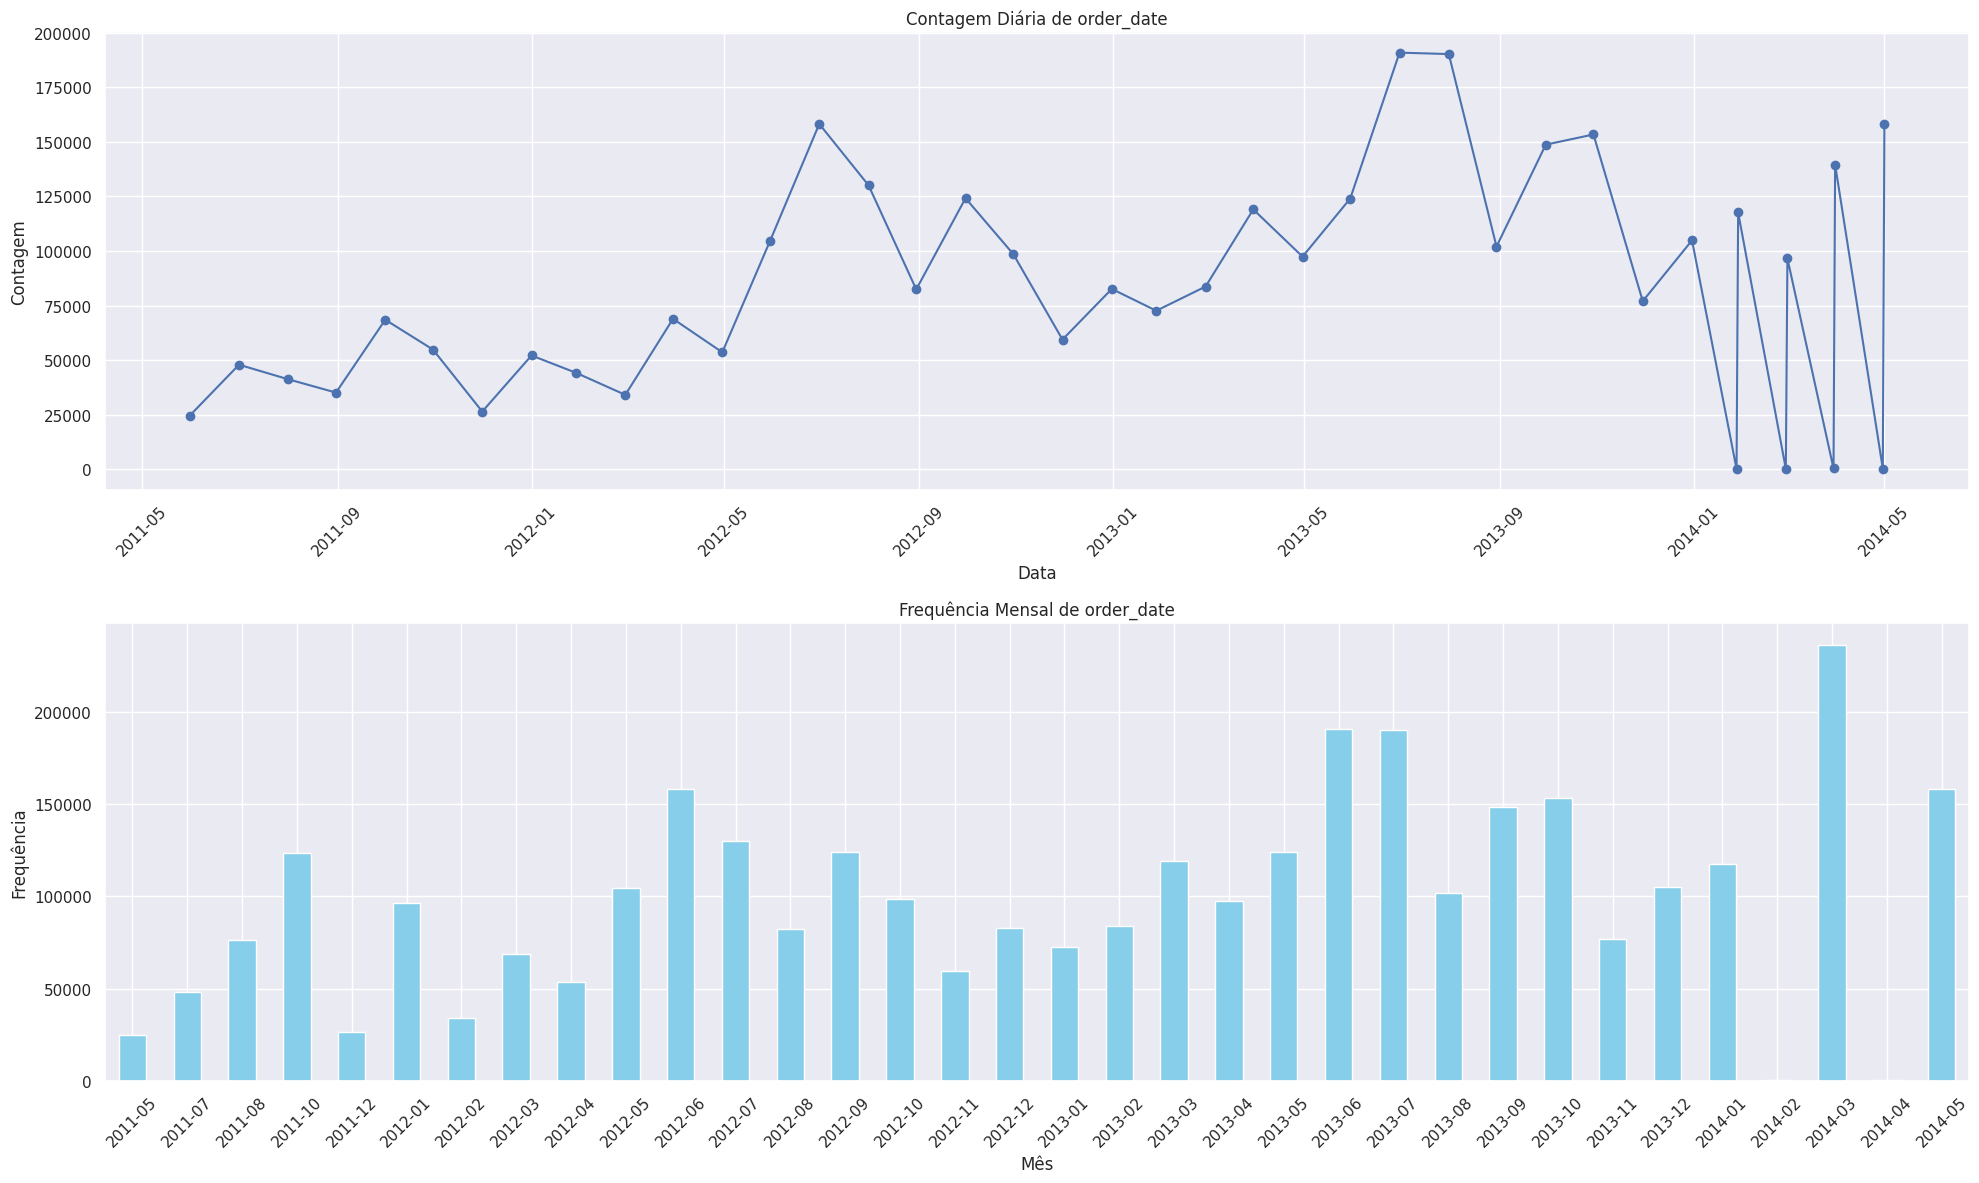

In [26]:
plot_temporal_column_distribution(df_demanda, 'order_date')

In [27]:
# resample para frequência diária/mensal
df_demanda['order_date'] = pd.to_datetime(df_demanda['order_date'], errors='coerce')
df_demanda.set_index('order_date', inplace=True)
daily_sales = df_demanda['order_quantity'].resample('D').sum().reset_index()
grouped_sales = df_demanda['order_quantity'].resample('M').sum().reset_index()
print(f'Daily Sales: {daily_sales.shape}')
print(daily_sales.sample(3))
print(f'Grouped Sales: {grouped_sales.shape}')
print(grouped_sales.head(3))

Daily Sales: (1067, 2)
     order_date  order_quantity
1056 2014-04-21               0
801  2013-08-09               0
254  2012-02-09               0
Grouped Sales: (37, 2)
  order_date  order_quantity
0 2011-05-31           58103
1 2011-06-30               0
2 2011-07-31          124388


In [28]:
# filtrar dias sem vendas
daily_sales = daily_sales[daily_sales['order_quantity'] > 0]
grouped_sales = grouped_sales[grouped_sales['order_quantity'] > 0]
print(f'Daily Sales (Filtrado): {daily_sales.shape}')
print(daily_sales.sample(3))
print(f'Grouped Sales (Filtrado): {grouped_sales.shape}')
print(grouped_sales.head(3))

Daily Sales (Filtrado): (40, 2)
    order_date  order_quantity
304 2012-03-30          181850
973 2014-01-28             200
396 2012-06-30          571795
Grouped Sales (Filtrado): (34, 2)
  order_date  order_quantity
0 2011-05-31           58103
2 2011-07-31          124388
3 2011-08-31          192333


# <h1 align="center"><font color = #0081be>Serie Temporal - Testes

<h5><font color = #0081be><b>1.</b></font> A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.</h5>

In [29]:
# criando as séries temporais com diferentes granularidades
daily_sales_series = df_demanda['order_quantity'].resample('D').sum()
monthly_sales_series = df_demanda['order_quantity'].resample('M').sum()
yearly_sales_series = df_demanda['order_quantity'].resample('Y').sum()

In [30]:
def plot_series_analysis(series, title_prefix, figsize=(18, 12)):
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    # série Original
    axes[0].plot(series, marker='o', linestyle='-', label='Série Original')
    axes[0].set_title(f'{title_prefix} - Série Original')
    axes[0].set_xlabel('Tempo')
    axes[0].set_ylabel('Valores')
    axes[0].legend()
    # média Móvel (3 meses)
    rolling_mean = series.rolling(window=3).mean()
    axes[1].plot(series, color='gray', alpha=0.5, linestyle='--', label='Série Original')
    axes[1].plot(rolling_mean, color='orange', marker='o', label='Média Móvel (3 meses)')
    axes[1].set_title(f'{title_prefix} - Média Móvel (3 meses)')
    axes[1].set_xlabel('Tempo')
    axes[1].set_ylabel('Valores')
    axes[1].legend()
    # decomposição Sazonal (se aplicável)
    try:
        result = seasonal_decompose(series, model='additive', period=12)
        axes[2].plot(result.seasonal, color='purple', linestyle='-', label='Sazonalidade')
        axes[2].set_title(f'{title_prefix} - Componente Sazonal')
        axes[2].set_xlabel('Tempo')
        axes[2].set_ylabel('Valores')
        axes[2].legend()
    except ValueError:
        axes[2].text(0.5, 0.5, 'Decomposição não aplicável para esta série',
                     fontsize=12, ha='center', va='center', color='red')
        axes[2].set_title(f'{title_prefix} - Componente Sazonal')
        axes[2].axis('off')
    plt.tight_layout()
    plt.show()
def plot_multiple_series(series_list, titles, figsize=(18, 12)):
    """
    Plota análises para múltiplas séries temporais.

    Parâmetros:
    - series_list: List[pd.Series] - Lista de séries temporais.
    - titles: List[str] - Títulos para as séries.
    - figsize: Tuple[int, int] - Tamanho de cada conjunto de gráficos.

    Retorno:
    - None
    """
    for series, title in zip(series_list, titles):
        plot_series_analysis(series, title, figsize)


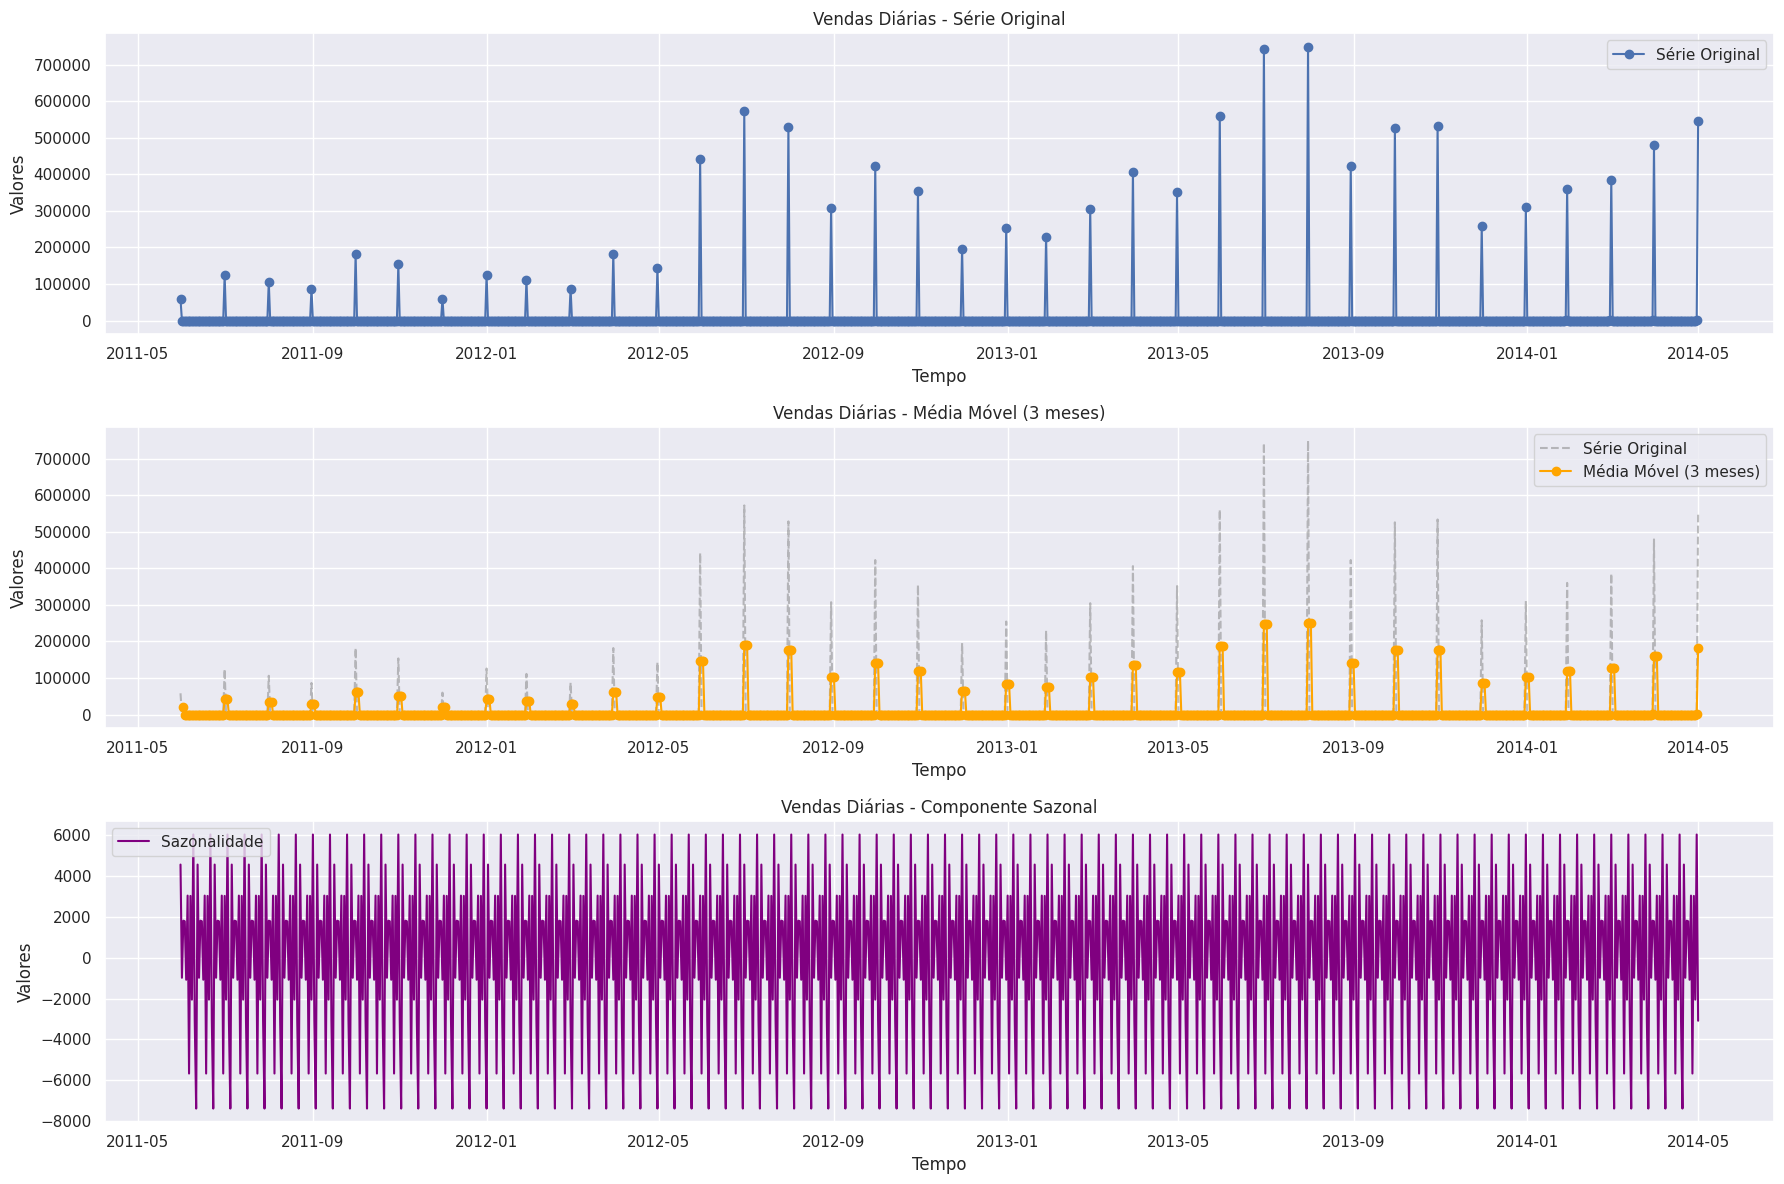

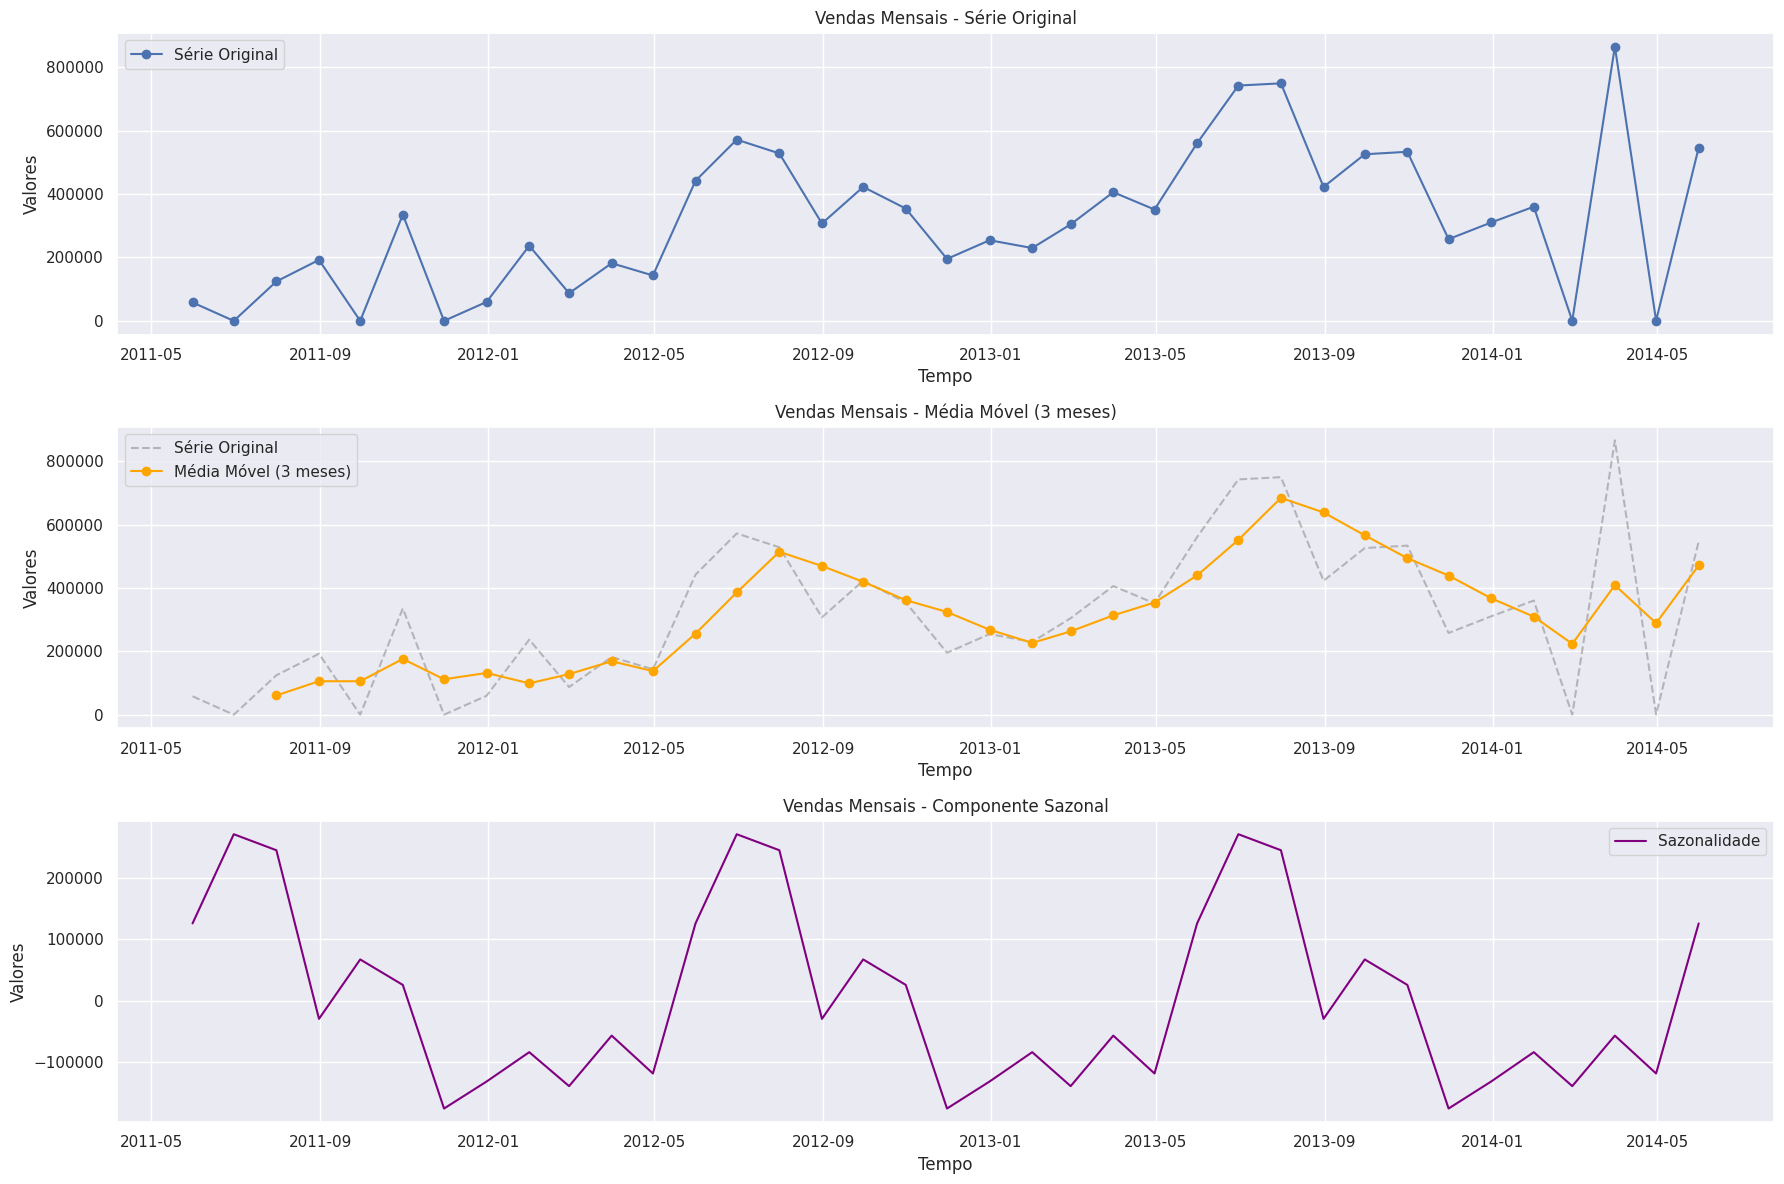

In [31]:
# lista de séries incluindo a diária e mensal
series_list = [daily_sales_series, monthly_sales_series]
titles = ['Vendas Diárias',  'Vendas Mensais']
plot_multiple_series(series_list, titles)

In [32]:
# função para analisar estacionariedade com teste ADF
def analyze_stationarity(series, title="Série Temporal"):
    # teste ADF
    adf_result = adfuller(series.dropna())  # remove valores NaN antes do teste
    print("Resultados do Teste ADF:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Valores Críticos:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.4f}")

    # interpretação do resultado
    if adf_result[1] <= 0.05:
        print("\nConclusão: A série é estacionária (Rejeita-se H0)")
    else:
        print("\nConclusão: A série não é estacionária (Não se rejeita H0)")
    print("-" * 50)

# aplicando a análise de estacionariedade
print("Analisando a série diária:")
analyze_stationarity(daily_sales_series, title="Vendas Diárias")

print("Analisando a série mensal:")
analyze_stationarity(monthly_sales_series, title="Vendas Mensais")


Analisando a série diária:
Resultados do Teste ADF:
ADF Statistic: -32.4907
p-value: 0.0000
Valores Críticos:
  1%: -3.4365
  5%: -2.8643
  10%: -2.5682

Conclusão: A série é estacionária (Rejeita-se H0)
--------------------------------------------------
Analisando a série mensal:
Resultados do Teste ADF:
ADF Statistic: -2.3958
p-value: 0.1429
Valores Críticos:
  1%: -3.6327
  5%: -2.9485
  10%: -2.6130

Conclusão: A série não é estacionária (Não se rejeita H0)
--------------------------------------------------


*A análise mostrou que a série diária de vendas é estacionária, indicando ausência de tendências ou sazonalidade significativa. Já a série mensal de vendas não é estacionária, sugerindo a presença de tendências ou padrões sazonais que devem ser modelados.*

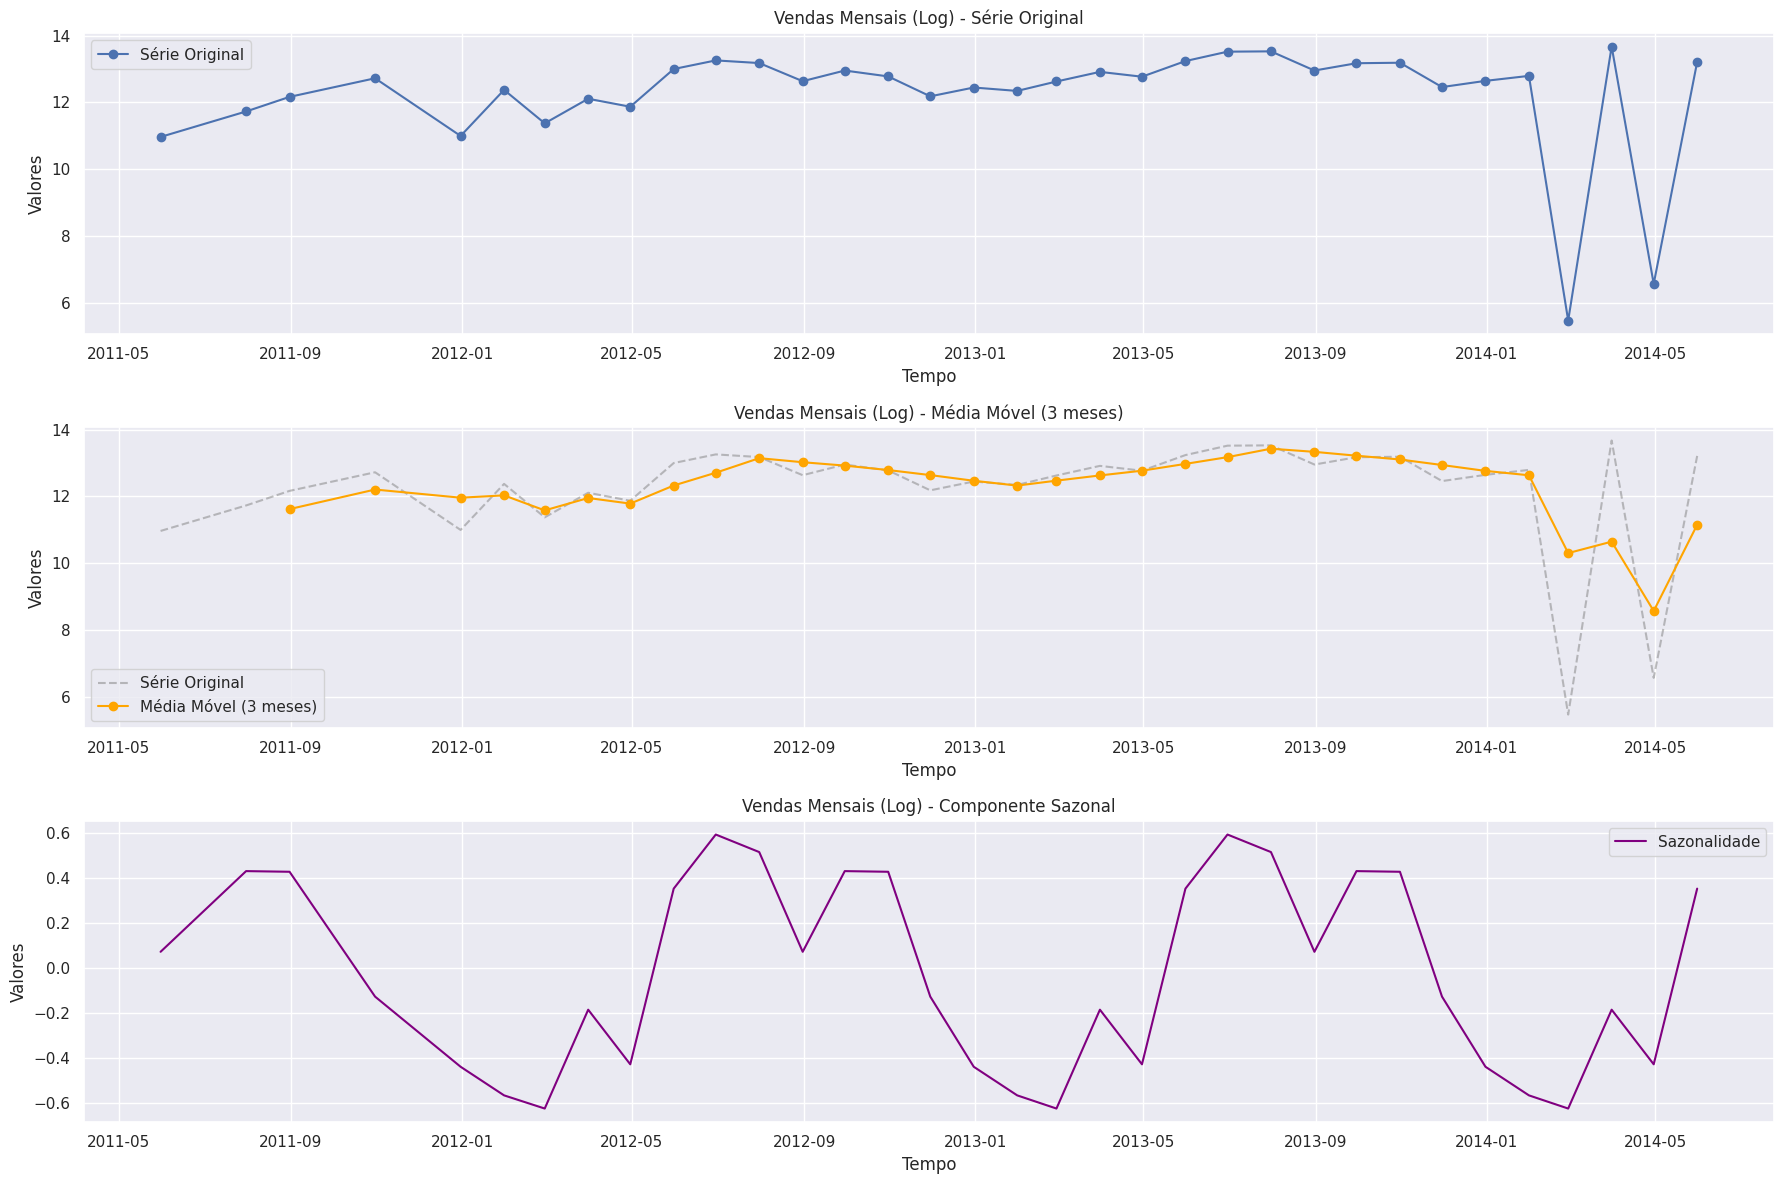

In [33]:
# transformação logarítmica (tratando valores zero ou negativos)
log_monthly_sales_series = np.log(monthly_sales_series.replace(0, np.nan) + 1)
# remover valores NaN
log_monthly_sales_series = log_monthly_sales_series.dropna()
# análise da série logarítmica mensal
plot_multiple_series(
    series_list=[log_monthly_sales_series],
    titles=["Vendas Mensais (Log)"],
    figsize=(18, 12)
)


In [34]:
# função de análise de estacionariedade
def analyze_log_series_stationarity(series, title="Série Log Transformada"):
    print(f"Analisando a estacionariedade de: {title}\n")
    # teste ADF
    adf_result = adfuller(series)
    print("Resultados do Teste ADF:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Valores Críticos:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.4f}")
    # interpretação
    if adf_result[1] <= 0.05:
        print("\nConclusão: A série é estacionária (Rejeita-se H0)")
    else:
        print("\nConclusão: A série não é estacionária (Não se rejeita H0)")
#  teste ADF na série log transformada
analyze_log_series_stationarity(log_monthly_sales_series, title="Vendas Mensais (Log)")

Analisando a estacionariedade de: Vendas Mensais (Log)

Resultados do Teste ADF:
ADF Statistic: -1.4920
p-value: 0.5375
Valores Críticos:
  1%: -3.6535
  5%: -2.9572
  10%: -2.6176

Conclusão: A série não é estacionária (Não se rejeita H0)


*A transformação logarítmica foi aplicada à série mensal de vendas para reduzir a amplitude das variações e suavizar o impacto de valores extremos. No entanto, os resultados do teste ADF indicam que, mesmo após a transformação, a série não é estacionária, com um p-valor de 0.5375 (> 0.05). Isso sugere que a série ainda apresenta tendência ou sazonalidade que precisam ser tratadas antes de aplicar modelos que exigem estacionariedade, como ARIMA.*

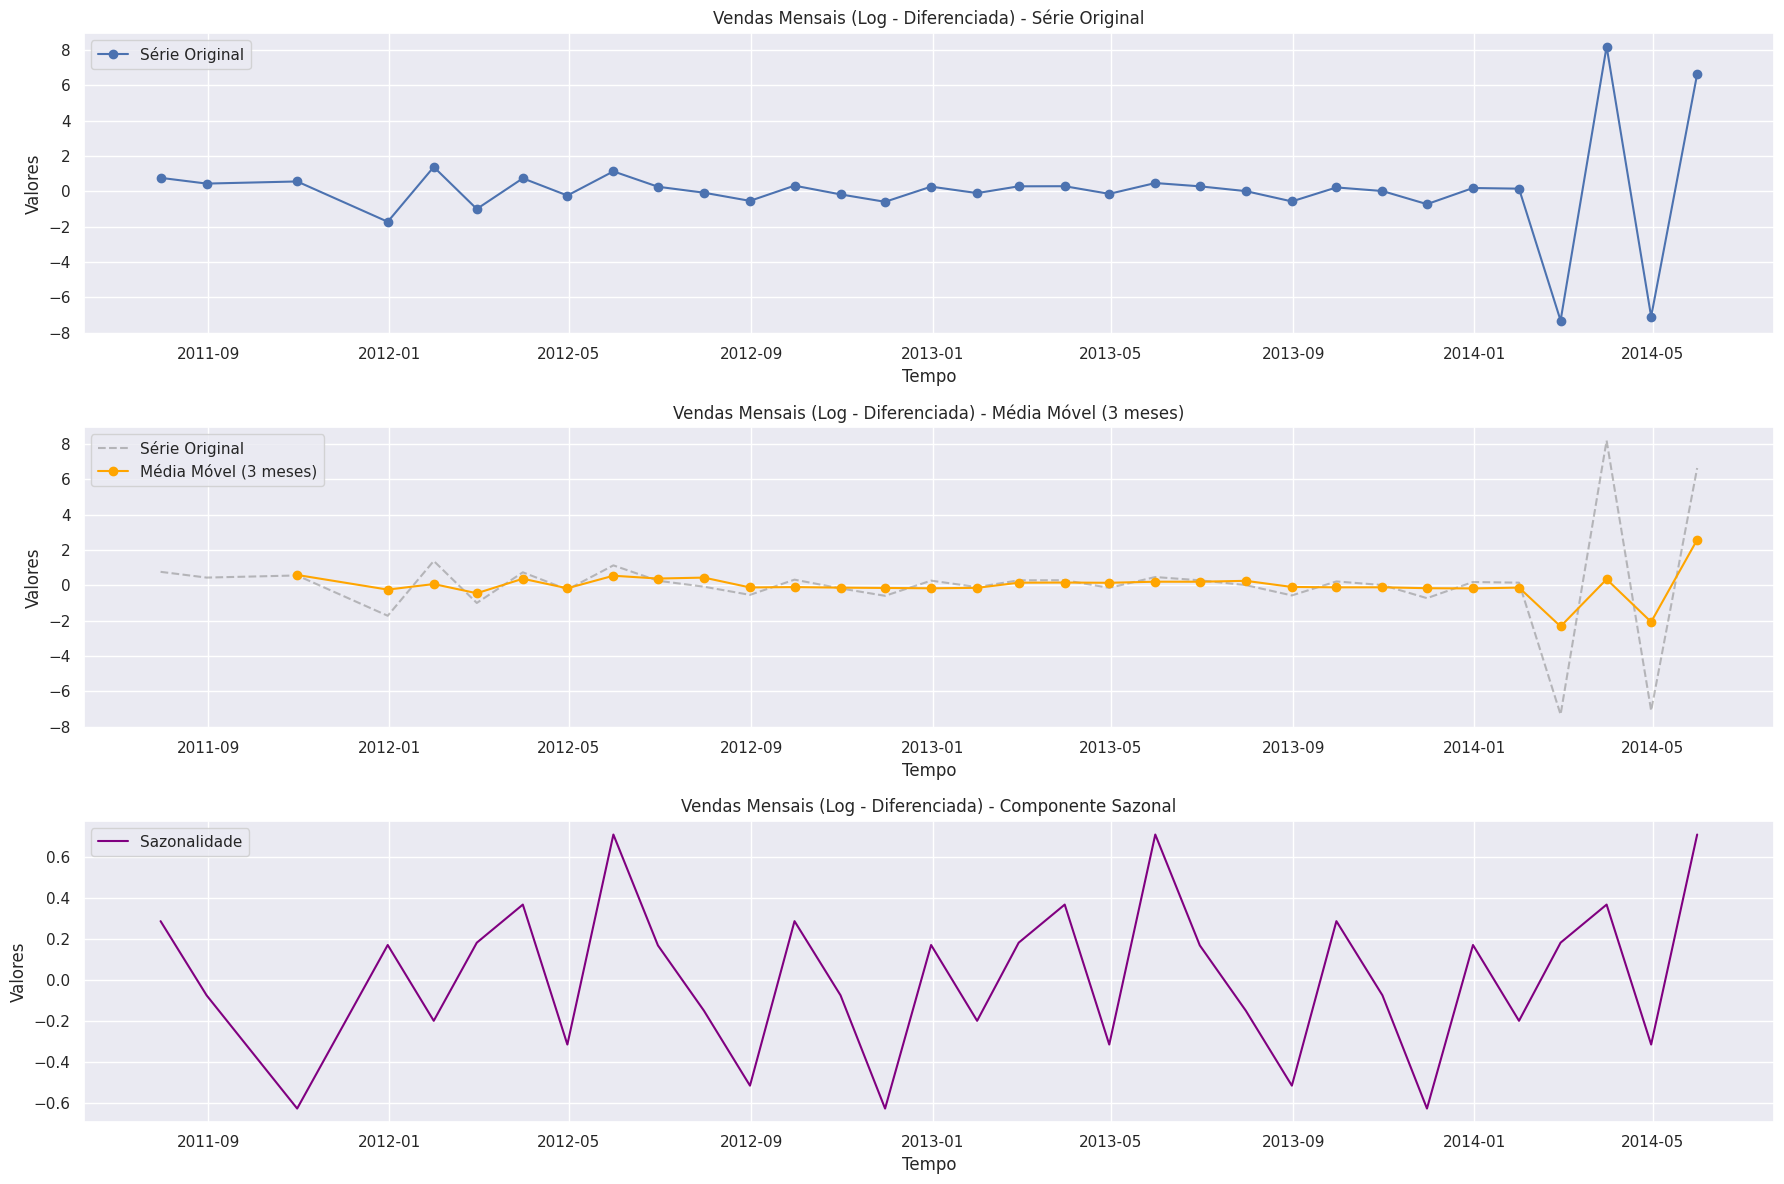

In [35]:
# transformação logarítmica (tratando valores zero ou negativos)
log_monthly_sales_series = np.log(monthly_sales_series.replace(0, np.nan) + 1)
log_monthly_sales_series = log_monthly_sales_series.dropna()
# primeira diferença da série logarítmica
log_diff_series = log_monthly_sales_series.diff().dropna()
plot_multiple_series(
    series_list=[log_diff_series],
    titles=["Vendas Mensais (Log - Diferenciada)"],
    figsize=(18, 12)
)

In [36]:
# teste adf na série diferenciada
analyze_log_series_stationarity(log_diff_series, title="Vendas Mensais (Log - Diferenciada)")

Analisando a estacionariedade de: Vendas Mensais (Log - Diferenciada)

Resultados do Teste ADF:
ADF Statistic: -18.0038
p-value: 0.0000
Valores Críticos:
  1%: -3.6535
  5%: -2.9572
  10%: -2.6176

Conclusão: A série é estacionária (Rejeita-se H0)


*A diferenciação foi aplicada à série logarítmica para remover tendências e tornar a série estacionária. O teste ADF confirmou a estacionariedade, com um p-valor de 0.0000 (< 0.05), indicando que a série agora está pronta para modelagem.*

In [37]:
def adf_tests_on_series(series_list, titles):
    results = []

    for series, title in zip(series_list, titles):
        adf_result = adfuller(series.dropna())  # remove NaN antes do teste
        results.append({
            "Série": title,
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "1% Critical Value": adf_result[4]['1%'],
            "5% Critical Value": adf_result[4]['5%'],
            "10% Critical Value": adf_result[4]['10%'],
            "Estacionária": "Sim" if adf_result[1] <= 0.05 else "Não"
        })
    results_df = pd.DataFrame(results)
    return results_df
# séries e títulos
series_list = [monthly_sales_series, log_monthly_sales_series, log_monthly_sales_series.diff().dropna()]
titles = ["Monthly Sales Series", "Log Series", "Log Series (Differenced)"]
results_df = adf_tests_on_series(series_list, titles)
results_df

,Série,ADF Statistic,p-value,1% Critical Value,5% Critical Value,10% Critical Value,Estacionária
0,Monthly Sales Series,-2.396,0.143,-3.633,-2.949,-2.613,Não
1,Log Series,-1.492,0.537,-3.654,-2.957,-2.618,Não
2,Log Series (Differenced),-18.004,0.000,-3.654,-2.957,-2.618,Sim


*O dataframe acima resume as transformações aplicadas à série e seus impactos na estacionariedade, com base no teste ADF. Os resultados indicam sazonalidade e tendência nas vendas. Após a diferenciação, as séries ficaram estacionárias, permitindo o uso do AutoARIMA para prever a demanda dos próximos 3 meses por produto e loja.*

# <h1 align="center"><font color = #0081be>Serie Temporal - Forecast

In [38]:
df = monthly_sales_series

In [39]:
# corrigindo valores zero para evitar problemas com o logaritmo
df = df.replace(0, np.nan)
log_series = np.log(df).dropna()
janela_movel = 3
ma_log = log_series.rolling(janela_movel).mean()
df_sub = (log_series - ma_log).dropna()
df_diff = df_sub.diff().dropna()

# Verificando os resultados
print(f'data mais antiga: {df_sub.index[0]}')
print(f'data mais recente: {df_sub.index[-1]}')

data mais antiga: 2011-08-31 00:00:00
data mais recente: 2014-05-31 00:00:00


In [40]:
def data_filter(df, start_date, end_date, unique_id='1'):
    # filtrando os dados conforme o intervalo de datas
    filtro = df[(df.index >= start_date) & (df.index <= end_date)].reset_index()
    filtro.columns = ['ds', 'y']
    filtro['unique_id'] = unique_id
    return filtro
#intervalo de datas
start = '2011-08'
end = '2014-05'
filtro = data_filter(df_sub, start, end)

In [41]:
def prepara_dados(df, id_unico='1'):
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce').dt.to_period('M').dt.to_timestamp()
    if 'y' not in df.columns:
        raise ValueError("O DataFrame deve conter a coluna 'y'.")
    df = df[['ds', 'y']]
    df['unique_id'] = id_unico

    return df
filtro_formatado = prepara_dados(filtro, id_unico=1)

In [42]:
# os modelos
models = [
    Naive(),
    AutoARIMA(season_length=12),
]
# objeto StatsForecast com os modelos e a frequência desejada
sf = StatsForecast(
    models=models,
    freq='MS',
)
# modelo aos dados
sf.fit(filtro_formatado)  # passando os dados para a função fit
# fazendo a previsão com o horizonte de 3 meses e intervalo de confiança de 95%
forecast = sf.predict(h=3, level=[95])

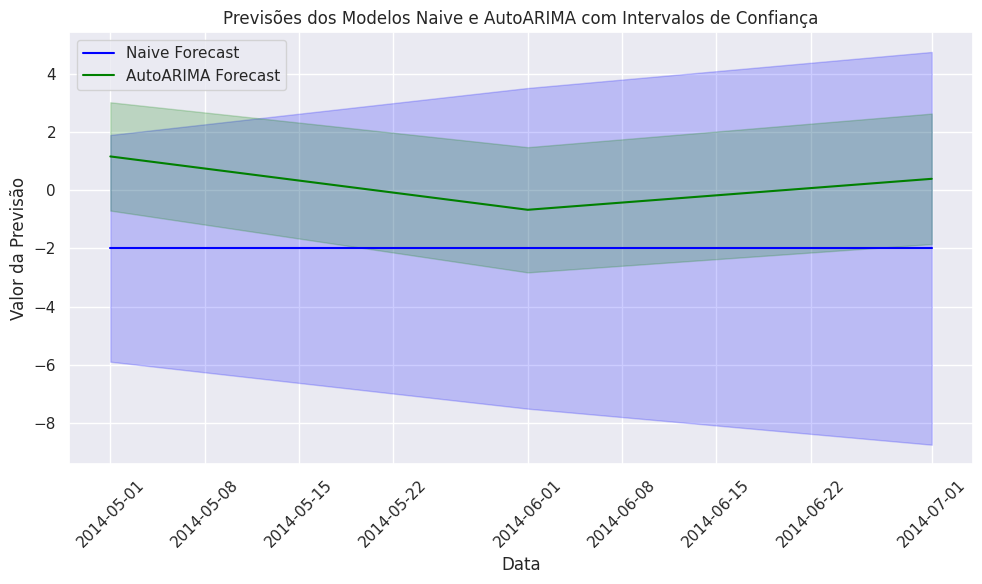

In [43]:
df_resultado = forecast
# plotando as previsões para os modelos Naive e AutoARIMA
plt.figure(figsize=(10, 6))
plt.plot(df_resultado['ds'], df_resultado['Naive'], label='Naive Forecast', color='blue')
plt.fill_between(df_resultado['ds'], df_resultado['Naive-lo-95'], df_resultado['Naive-hi-95'], color='blue', alpha=0.2)
plt.plot(df_resultado['ds'], df_resultado['AutoARIMA'], label='AutoARIMA Forecast', color='green')
plt.fill_between(df_resultado['ds'], df_resultado['AutoARIMA-lo-95'], df_resultado['AutoARIMA-hi-95'], color='green', alpha=0.2)
plt.title('Previsões dos Modelos Naive e AutoARIMA com Intervalos de Confiança')
plt.xlabel('Data')
plt.ylabel('Valor da Previsão')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*O modelo Naive está constantemente prevendo uma queda, mas com intervalos de confiança amplos, o que indica uma alta incerteza nas previsões. Já o modelo AutoARIMA apresenta previsões mais variadas, com tanto valores negativos quanto positivos, mas também com intervalos de confiança grandes, sugerindo incerteza. Em ambos os modelos, os intervalos de confiança de 95% são amplos, o que pode indicar que as previsões não são muito precisas.*

In [44]:
y_true = filtro_formatado['y'].iloc[-3:].reset_index(drop=True)  # alinhando com a previsão
y_pred_naive = forecast['Naive'].iloc[:3].reset_index(drop=True)
y_pred_autoarima = forecast['AutoARIMA'].iloc[:3].reset_index(drop=True)
# métricas
mae_naive = mean_absolute_error(y_true, y_pred_naive)
mae_autoarima = mean_absolute_error(y_true, y_pred_autoarima)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))
rmse_autoarima = np.sqrt(mean_squared_error(y_true, y_pred_autoarima))
mse_naive = mean_squared_error(y_true, y_pred_naive)
mse_autoarima = mean_squared_error(y_true, y_pred_autoarima)
metrics_df = pd.DataFrame({
    'Modelo': ['Naive', 'AutoARIMA'],
    'MAE': [mae_naive, mae_autoarima],
    'RMSE': [rmse_naive, rmse_autoarima],
    'MSE': [mse_naive, mse_autoarima]
})
print("Métricas dos Modelos:")
print(metrics_df)
comparison_df = pd.DataFrame({
    'Data': filtro_formatado['ds'].iloc[-3:].reset_index(drop=True),
    'Valor Real': y_true,
    'Previsão Naive': y_pred_naive,
    'Previsão AutoARIMA': y_pred_autoarima
})
print("\nComparação entre Valores Reais e Previstos:")
print(comparison_df)

Métricas dos Modelos:
      Modelo   MAE  RMSE    MSE
0      Naive 2.616 3.327 11.067
1  AutoARIMA 4.023 4.289 18.398

Comparação entre Valores Reais e Previstos:
        Data  Valor Real  Previsão Naive  Previsão AutoARIMA
0 2014-02-01      -4.826          -1.998               1.160
1 2014-03-01       3.022          -1.998              -0.673
2 2014-04-01      -1.998          -1.998               0.391


*Embora o Naive tenha apresentado menor erro médio nas métricas, ambos os modelos mostram grande incerteza nas previsões, indicada pelos amplos intervalos de confiança. O Naive é mais estável, com previsões consistentes de queda, enquanto o AutoARIMA captura flutuações mais complexas, mas com maior variação e incerteza.*

# <h1 align="center"><font color = #0081be>Hierarchical Forecast

In [45]:
df = df_demanda
df.sample(2)

,product_id,territory_name,countryregion_code,online_order_flag,sales_person_id,unit_price,unit_price_discount,order_quantity,freight,store_name,product_name,product_number,name_product_category,name_product_subcategory,state_province_name,total_inventory,total_orders,country_store_group
order_date,,,,,,,,,,,,,,,,,,
2013-04-30,861,canada,ca,False,289,22.794,0.000,4,342.233,shipping specialists,"full-finger gloves, s",gl-f110-s,clothing,gloves,england,72,1,CA - Canada
2013-11-30,977,southwest,us,False,275,323.994,0.000,4,"1,685.370",wheelsets storehouse,"road-750 black, 58",bk-r19b-58,bikes,road bikes,maine,153,1,US - Southwest


# <h1 align="center"><font color = #0081be>ML Prediction Algorithms


  <h5><font color = #0081be><b>2.</b></font> Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.</h5>



Sim, seria possível resolver este problema utilizando modelos de regressão, pois a base de dados possui variáveis contínuas, como a ***ORDER_QUANTITY***, que é ideal para modelagem preditiva. *texto em itálico*

In [46]:
df2 = df.copy()
df2.sample(2)

,product_id,territory_name,countryregion_code,online_order_flag,sales_person_id,unit_price,unit_price_discount,order_quantity,freight,store_name,product_name,product_number,name_product_category,name_product_subcategory,state_province_name,total_inventory,total_orders,country_store_group
order_date,,,,,,,,,,,,,,,,,,
2012-02-29,760,northeast,us,False,275,419.459,0.000,1,724.136,retail sales and service,"road-650 red, 60",bk-r50r-60,bikes,road bikes,new hampshire,185,1,US - Northeast
2014-03-31,969,france,fr,False,290,"1,430.442",0.000,5,"3,381.533",spare parts co.,"touring-1000 blue, 60",bk-t79u-60,bikes,touring bikes,seine (paris),129,1,FR - France


# <h1 align="center"><font color = #0081be>Previsão de demanda de luvas

 <h5><font color = #0081be><b>4.</b></font> Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?